In [1]:
# create modeling spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName('Project 1 modeling')
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "8g")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

In [2]:
########################################################################


# NOTE, Need to replace the working directions of the file, please do not include back slash at the end
# remove current directory and change it to your directory to the project


directory = "/Users/aobo/Desktop/project_1"



#########################################################################

In [3]:
# read full training data
sdf_Uber = spark.read.parquet(directory + '/data/curated/HVFH/train/full_HVFH_train.parquet')
sdf_Ytaxi = spark.read.parquet(directory + '/data/curated/ytaxi/train/full_ytaxi_train.parquet')

# even though null value is removed in preprocessing, remove again just in case
sdf_Uber = sdf_Uber.dropna('any')
sdf_Ytaxi = sdf_Ytaxi.dropna('any')

In [4]:
# vectorize selected features from correlation visualisation
from pyspark.ml.feature import VectorAssembler

features = 'features'
# selected feature are obtained from visualisation, where the pearson correlations are higher than 0.1
uber_input_cols = ['DOLocationID','trip_miles', 'trip_time']
ytaxi_input_cols = ['trip_distance', 'trip_Time','RatecodeID']

Uber_assembler = VectorAssembler(
    # which column to combine
    inputCols=uber_input_cols, 
    # How should the combined columns be named
    outputCol=features
)

ytaxi_assembler = VectorAssembler(
    # which column to combine
    inputCols=ytaxi_input_cols, 
    # How should the combined columns be named
    outputCol=features
)
# remove any null value in the dataframe
# even though this is done in preprocessing, double check to ensure that training is good
Uber_model_sdf = Uber_assembler.transform(sdf_Uber)
Ytaxi_model_sdf = ytaxi_assembler.transform(sdf_Ytaxi)


In [5]:
# import linear regression from pyspark
# also import generalized linear regression since trip cost data show a gamma distribution (right skewed)
from pyspark.ml.regression import LinearRegression
import time
import pandas as pd


In [6]:
# conduct uber's linear regression model
start = time.time()
uber_linear = LinearRegression(featuresCol='features', labelCol='total_amount').fit(Uber_model_sdf)
print(time.time()-start)
# last model runtime 94

107.67938590049744


In [7]:
# conduct yellow taxi's linear regression model
start = time.time()
ytaxi_linear = LinearRegression(featuresCol='features', labelCol='total_amount').fit(Ytaxi_model_sdf)
print(time.time()-start)
# last model runtime 45

43.409226179122925


In [8]:
# read testing files: September 2019, for Uber and Yellow taxi
sdf_Uber_prediction = spark.read.parquet(directory + '/data/curated/HVFH/test/final_0919HVFH.parquet')
sdf_ytaxi_prediction = spark.read.parquet(directory + '/data/curated/ytaxi/test/final_0919ytaxi.parquet')

# even though null value is removed in preprocessing, remove again just in case
sdf_Uber_prediction = sdf_Uber_prediction.dropna('any')
sdf_ytaxi_prediction = sdf_ytaxi_prediction.dropna('any')

In [9]:
# preprocess for predictions for uber, get all features in vector form

predict_test = sdf_Uber_prediction.select(*uber_input_cols,'total_amount')

Uber_predict_sdf = Uber_assembler.transform(predict_test)

Uber_predict_sdf.limit(5)

DOLocationID,trip_miles,trip_time,total_amount,features
169,1.63,426,7.51,"[169.0,1.63,426.0]"
18,1.6,556,9.21,"[18.0,1.6,556.0]"
198,18.01,1678,29.09,"[198.0,18.01,1678.0]"
112,0.88,325,8.01,"[112.0,0.88,325.0]"
107,4.96,1271,20.62,"[107.0,4.96,1271.0]"


In [10]:
# preprocess for predictions for yellow taxi,  get all features in vector form
predict_test = sdf_ytaxi_prediction.select(*ytaxi_input_cols,'total_amount')

Ytaxi_predict_sdf = ytaxi_assembler.transform(predict_test)

Ytaxi_predict_sdf.limit(5)

trip_distance,trip_Time,RatecodeID,total_amount,features
2.0,1138,1.0,16.8,"[2.0,1138.0,1.0]"
5.5,1717,1.0,26.3,"[5.5,1717.0,1.0]"
2.9,4,1.0,3.8,"[2.9,4.0,1.0]"
1.5,325,1.0,8.3,"[1.5,325.0,1.0]"
8.3,2195,1.0,39.96,"[8.3,2195.0,1.0]"


In [11]:
# obtain linear regression prediction for Uber
uber_lr_prediction = uber_linear.transform(Uber_predict_sdf)
uber_lr_prediction.limit(5)


DOLocationID,trip_miles,trip_time,total_amount,features,prediction
169,1.63,426,7.51,"[169.0,1.63,426.0]",8.507885839488226
18,1.6,556,9.21,"[18.0,1.6,556.0]",7.054626963209339
198,18.01,1678,29.09,"[198.0,18.01,1678.0]",59.73527554591401
112,0.88,325,8.01,"[112.0,0.88,325.0]",5.0988230885188885
107,4.96,1271,20.62,"[107.0,4.96,1271.0]",21.538509994761064


In [12]:
# obtain linear regression prediction for Yellow taxi
ytaxi_lr_prediction = ytaxi_linear.transform(Ytaxi_predict_sdf)
ytaxi_lr_prediction.limit(5)

trip_distance,trip_Time,RatecodeID,total_amount,features,prediction
2.0,1138,1.0,16.8,"[2.0,1138.0,1.0]",17.89807093522201
5.5,1717,1.0,26.3,"[5.5,1717.0,1.0]",29.873914829578055
2.9,4,1.0,3.8,"[2.9,4.0,1.0]",14.037174683773163
1.5,325,1.0,8.3,"[1.5,325.0,1.0]",12.236397635227922
8.3,2195,1.0,39.96,"[8.3,2195.0,1.0]",39.53465779800557


In [13]:
from pyspark.ml.evaluation import RegressionEvaluator

In [14]:
# evaluate linear regression prediction, create evaluation metric of root-mean-square deviation
rmse_evaluator = RegressionEvaluator(
    labelCol="total_amount", predictionCol="prediction", metricName="rmse")

In [15]:
# create r^2 evaluator
r2_evaluator = RegressionEvaluator(
    labelCol="total_amount", predictionCol="prediction", metricName="r2")

In [16]:
# evaluate yellow taxi's linear regression on rmse
ytaxi_lr_rmse = rmse_evaluator.evaluate(ytaxi_lr_prediction)
print("Root Mean Squared Error (RMSE) on Yellow taxi's trip data = %g" % ytaxi_lr_rmse)

Root Mean Squared Error (RMSE) on Yellow taxi's trip data = 5.15711


In [17]:
# evaluate yellow taxi's linear regression on r-squared
ytaxi_lr_r2 = r2_evaluator.evaluate(ytaxi_lr_prediction)
print("R Squared (R^2) on Yellow taxi's trip data = %g" % ytaxi_lr_r2)

R Squared (R^2) on Yellow taxi's trip data = 0.876661


In [18]:
# evaluate Uber's linear regression on rmse
uber_lr_rmse = rmse_evaluator.evaluate(uber_lr_prediction)
print("Root Mean Squared Error (RMSE) on Uber's trip data = %g" % uber_lr_rmse)

Root Mean Squared Error (RMSE) on Uber's trip data = 10.199


In [19]:
# evaluate Uber's linear regression on r-squared
uber_lr_r2 = r2_evaluator.evaluate(uber_lr_prediction)
print("R Squared (R^2) on Uber's trip data = %g" % uber_lr_r2)

R Squared (R^2) on Uber's trip data = 0.778073


In [20]:
# Use another machine learning model to study the training data
# conduct gradient boost tree regression
from pyspark.ml.regression import GBTRegressor

In [21]:
# Use gradient boost tree regression to train the data
# Train a GBT model on Uber

start = time.time()

# take a sample of the full Uber training data. 100 million trip records is too much for gradient boosted 
# decision tree model, take 10 million as sample, that is 0.1 of the full data
# 0.1 represent the fraction of full trip data that is sampled
uber_sample = Uber_model_sdf.sample(False, 0.1)

# train the model based on the sample
uber_gbtr_model = GBTRegressor(featuresCol='features', labelCol='total_amount', 
                               maxIter=10).fit(uber_sample)
print(time.time()-start)
# last runtime is 250 seconds

241.50389695167542


In [22]:
# Train a GBT model on yellow taxi's trip data
start = time.time()

# take a sample of the full yellow taxi training data. 50 million trip records is too much for gradient 
# boosted decision tree model, take 10 million as sample, that is 0.2 of the full data
# 0.2 represent the fraction of full trip data that is sampled
ytaxi_sample = Ytaxi_predict_sdf.sample(False, 0.2)

# train the model based on the sample
ytaxi_gbtr_model = GBTRegressor(featuresCol='features', labelCol='total_amount', 
                               maxIter=10).fit(ytaxi_sample)
print(time.time()-start)
# last run time is 86 seconds

55.5467529296875


In [23]:
# obtain linear regression prediction for Uber,  get all features in vector form
uber_gbtr_prediction = uber_gbtr_model.transform(Uber_predict_sdf)
uber_gbtr_prediction.limit(5)

DOLocationID,trip_miles,trip_time,total_amount,features,prediction
169,1.63,426,7.51,"[169.0,1.63,426.0]",7.017095343620239
18,1.6,556,9.21,"[18.0,1.6,556.0]",9.730696891266616
198,18.01,1678,29.09,"[198.0,18.01,1678.0]",56.91508861178963
112,0.88,325,8.01,"[112.0,0.88,325.0]",8.118172218050452
107,4.96,1271,20.62,"[107.0,4.96,1271.0]",19.407448881309755


In [24]:
# obtain linear regression prediction for Yellow taxi,  get all features in vector form
ytaxi_gbtr_prediction = ytaxi_gbtr_model.transform(Ytaxi_predict_sdf)
ytaxi_gbtr_prediction.limit(5)

trip_distance,trip_Time,RatecodeID,total_amount,features,prediction
2.0,1138,1.0,16.8,"[2.0,1138.0,1.0]",19.321503326532987
5.5,1717,1.0,26.3,"[5.5,1717.0,1.0]",26.980896294295516
2.9,4,1.0,3.8,"[2.9,4.0,1.0]",10.323916326001184
1.5,325,1.0,8.3,"[1.5,325.0,1.0]",11.911319141038874
8.3,2195,1.0,39.96,"[8.3,2195.0,1.0]",40.32984289940157


In [26]:
# evaluate Uber's GBTR on rmse
uber_gbtr_rmse = rmse_evaluator.evaluate(uber_gbtr_prediction)
print("Root Mean Squared Error (RMSE) on Uber's trip data = %g" % uber_gbtr_rmse)

Root Mean Squared Error (RMSE) on Uber's trip data = 10.0267


In [27]:
# evaluate Uber's GBTR on r-squared
uber_gbtr_r2 = r2_evaluator.evaluate(uber_gbtr_prediction)
print("R Squared (R^2) on Yellow taxi's trip data = %g" % uber_gbtr_r2)

R Squared (R^2) on Yellow taxi's trip data = 0.785509


In [28]:
# evaluate yellow taxi's GBTR on rmse
ytaxi_gbtr_rmse = rmse_evaluator.evaluate(ytaxi_gbtr_prediction)
print("Root Mean Squared Error (RMSE) on Yellow taxi's trip data = %g" % ytaxi_gbtr_rmse)

Root Mean Squared Error (RMSE) on Yellow taxi's trip data = 4.00216


In [29]:
# evaluate yellow taxi's GBTR on r-squared
ytaxi_gbtr_r2 = r2_evaluator.evaluate(ytaxi_gbtr_prediction)
print("R Squared (R^2) on Yellow taxi's trip data = %g" % ytaxi_gbtr_r2)

R Squared (R^2) on Yellow taxi's trip data = 0.925719


In [24]:
# Gradient Boosted Tree Regression is better than linear regression
# compare the Gradient Boosted Tree Regression predictions for Yellow taxi and uber

In [39]:
# convert spark dataframe to pandas dataframe for pyplot histogram plot
start = time.time()
uber_gbtr = uber_gbtr_prediction.toPandas()
ytaxi_gbtr = ytaxi_gbtr_prediction.toPandas()
print(time.time()-start)

2282.892424106598


In [101]:
import numpy as np
import matplotlib.pyplot as plt

# dataset size is too big for histogram graph (over 8 million), take a sample of dataset for graph
# compare Uber and Yellow taxi sampled price
sample_HVFH = uber_gbtr.sample(100000)
sample_ytaxi = ytaxi_gbtr.sample(100000)


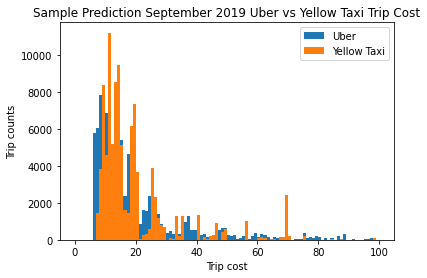

In [102]:
# plot the prediction cost of yellow taxi and Uber comparison
plt.hist(sample_HVFH["prediction"], bins=100, range=[0, 100],label = "Uber")
plt.hist(sample_ytaxi["prediction"], bins=100, range=[0, 100], label = "Yellow Taxi")

# add graph lables
plt.xlabel('Trip cost')
plt.ylabel('Trip counts')
plt.title('Sample Prediction September 2019 Uber vs Yellow Taxi Trip Cost')

# indicate color of different dataset
plt.legend(loc='upper right')

# save graph for analysis
plt.savefig(directory + '/plots/Uber_vs_Yellow_taxi_trip_cost_prediction')

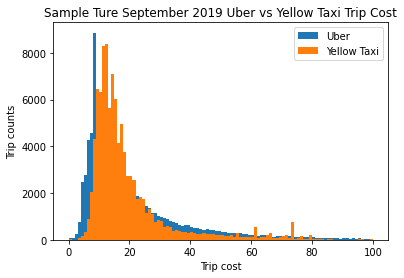

In [103]:
# plot the True cost of yellow taxi and Uber comparison
plt.hist(sample_HVFH["total_amount"], bins=100, range=[0, 100],label = "Uber")
plt.hist(sample_ytaxi["total_amount"], bins=100, range=[0, 100], label = "Yellow Taxi")

# add graph lables
plt.xlabel('Trip cost')
plt.ylabel('Trip counts')
plt.title('Sample Ture September 2019 Uber vs Yellow Taxi Trip Cost')

# indicate color of different dataset
plt.legend(loc='upper right')

# save graph for analysis
plt.savefig(directory + '/plots/Uber_vs_Yellow_taxi_trip_cost_true')

In [43]:
# now use compute another model for Uber and yellow taxi, with common feature trip time and trip distance
# and predict on the same dataset (Yellow taxi's dataset)

features = 'features'
uber_compare_input_cols = ['trip_miles', 'trip_time']
ytaxi_compare_input_cols = ['trip_distance', 'trip_Time']

Uber_compare_assembler = VectorAssembler(
    # which column to combine
    inputCols=uber_compare_input_cols, 
    # How should the combined columns be named
    outputCol=features
)

ytaxi_compare_assembler = VectorAssembler(
    # which column to combine
    inputCols=ytaxi_compare_input_cols, 
    # How should the combined columns be named
    outputCol=features
)
# remove any null value in the dataframe
# even though this is done in preprocessing, double check to ensure that training is good
Uber_compare_model = Uber_compare_assembler.transform(sdf_Uber)
Ytaxi_compare_model = ytaxi_compare_assembler.transform(sdf_Ytaxi)



In [51]:
# preprocess for predictions for uber

predict_compare_test = sdf_ytaxi_prediction.select(*ytaxi_compare_input_cols,'total_amount')

compare_prediction_sdf = ytaxi_compare_assembler.transform(predict_compare_test)

In [53]:
# Use GBTR as it's better than linear regression

start = time.time()

# take a sample of the full Uber training data. 100 million trip records is too much for gradient boosted 
# decision tree model, take 10 million as sample, that is 0.1 of the full data
# 0.1 represent the fraction of full trip data that is sampled
uber_sample = Uber_compare_model.sample(False, 0.1)

# train the model based on the sample
uber_compare_gbtr_model = GBTRegressor(featuresCol='features', labelCol='total_amount', 
                               maxIter=10).fit(uber_sample)
print(time.time()-start)

281.6166160106659


In [54]:
# Train a GBT model on yellow taxi's trip data
start = time.time()

# take a sample of the full yellow taxi training data. 50 million trip records is too much for gradient 
# boosted decision tree model, take 10 million as sample, that is 0.2 of the full data
# 0.2 represent the fraction of full trip data that is sampled
ytaxi_sample = Ytaxi_compare_model.sample(False, 0.2)

# train the model based on the sample
ytaxi_compare_gbtr_model = GBTRegressor(featuresCol='features', labelCol='total_amount', 
                               maxIter=10).fit(ytaxi_sample)
print(time.time()-start)

210.61018013954163


In [ ]:
# predict based on the same data, with different model

In [55]:
# obtain linear regression prediction for Uber
compare_uber_gbtr_prediction = uber_compare_gbtr_model.transform(compare_prediction_sdf)
compare_ytaxi_gbtr_prediction = ytaxi_compare_gbtr_model.transform(compare_prediction_sdf)

In [56]:
compare_uber_gbtr_prediction.limit(5)

trip_distance,trip_Time,total_amount,features,prediction
2.0,1138,16.8,"[2.0,1138.0]",15.801850162727861
5.5,1717,26.3,"[5.5,1717.0]",23.752076198487867
2.9,4,3.8,"[2.9,4.0]",7.475622896774754
1.5,325,8.3,"[1.5,325.0]",7.424086369117854
8.3,2195,39.96,"[8.3,2195.0]",35.2749846816146


In [59]:
compare_ytaxi_gbtr_prediction.limit(5)

trip_distance,trip_Time,total_amount,features,prediction
2.0,1138,16.8,"[2.0,1138.0]",17.98673668319054
5.5,1717,26.3,"[5.5,1717.0]",27.09588466437247
2.9,4,3.8,"[2.9,4.0]",24.028469957721285
1.5,325,8.3,"[1.5,325.0]",11.874977632631458
8.3,2195,39.96,"[8.3,2195.0]",43.84441296317804


In [110]:
# evaluate Uber's GBTR on rmse
uber_gbtr_compare_rmse = rmse_evaluator.evaluate(compare_uber_gbtr_prediction)
print("Root Mean Squared Error (RMSE) on Uber's trip data = %g" % uber_gbtr_compare_rmse)

Root Mean Squared Error (RMSE) on Uber's trip data = 7.61719


In [111]:
# evaluate Uber's GBTR on r-squared
uber_gbtr_compare_r2 = r2_evaluator.evaluate(compare_uber_gbtr_prediction)
print("R Squared (R^2) on Yellow taxi's trip data = %g" % uber_gbtr_compare_r2)

R Squared (R^2) on Yellow taxi's trip data = 0.730923


In [112]:
# evaluate yellow taxi's GBTR on rmse
ytaxi_gbtr_compare_rmse = rmse_evaluator.evaluate(compare_ytaxi_gbtr_prediction)
print("Root Mean Squared Error (RMSE) on Yellow taxi's trip data = %g" % ytaxi_gbtr_compare_rmse)

Root Mean Squared Error (RMSE) on Yellow taxi's trip data = 5.53418


In [113]:
# evaluate yellow taxi's GBTR on r-squared
ytaxi_gbtr_compare_r2 = r2_evaluator.evaluate(compare_ytaxi_gbtr_prediction)
print("R Squared (R^2) on Yellow taxi's trip data = %g" % ytaxi_gbtr_compare_r2)

R Squared (R^2) on Yellow taxi's trip data = 0.857966


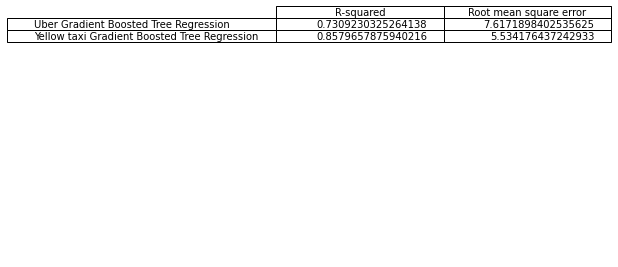

In [115]:
# create table for evaluation metrics
# set up row and column names
row = ['Uber Gradient Boosted Tree Regression',
      'Yellow taxi Gradient Boosted Tree Regression']
column = ['R-squared', 'Root mean square error']
# create a plot
fig, ax = plt.subplots(1,1)
ax.axis('off')
# allocate data
compare_celltext = [[uber_gbtr_compare_r2,uber_gbtr_compare_rmse],
            [ytaxi_gbtr_compare_r2,ytaxi_gbtr_compare_rmse]]
table = ax.table(cellText=compare_celltext, rowLabels=row, colLabels=column,loc='top') 


# remove surrounding empty spaces for the table
bbox = table.get_window_extent(fig.canvas.get_renderer())
bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())
# save the table figure
plt.savefig(directory + '/plots/Uber_vs_ytaxi_prediction_comparison_evaluation_metric', dpi=300, bbox_inches=bbox_inches)

In [60]:
# convert to pandas dataframe for pyplot histogram plot
start = time.time()
compare_uber_gbtr = compare_uber_gbtr_prediction.toPandas()
compare_ytaxi_gbtr = compare_ytaxi_gbtr_prediction.toPandas()
print(time.time()-start)

1578.5251603126526


In [62]:
compare_uber_gbtr

,trip_distance,trip_Time,total_amount,features,prediction
0,2.00,1138,16.80,"[2.0, 1138.0]",15.801850
1,5.50,1717,26.30,"[5.5, 1717.0]",23.752076
2,2.90,4,3.80,"[2.9, 4.0]",7.475623
3,1.50,325,8.30,"[1.5, 325.0]",7.424086
4,8.30,2195,39.96,"[8.3, 2195.0]",35.274985
...,...,...,...,...,...
6334161,1.54,467,14.12,"[1.54, 467.0]",8.822288
6334162,2.06,506,13.80,"[2.06, 506.0]",8.822288
6334163,0.96,353,12.25,"[0.96, 353.0]",7.424086
6334164,0.82,219,10.56,"[0.82, 219.0]",7.424086


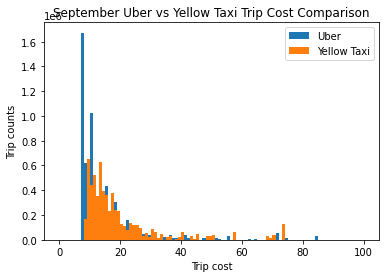

In [119]:
plt.hist(compare_uber_gbtr["prediction"], bins=100, range=[0, 100],label = "Uber")
plt.hist(compare_ytaxi_gbtr["prediction"], bins=100, range=[0, 100], label = "Yellow Taxi")

# add graph lables
plt.xlabel('Trip cost')
plt.ylabel('Trip counts')
plt.title('September Uber vs Yellow Taxi Trip Cost Comparison')

# indicate color of different dataset
plt.legend(loc='upper right')

# save graph for analysis
plt.savefig(directory + '/plots/Uber_vs_Yellow_taxi_trip_cost_comparison')

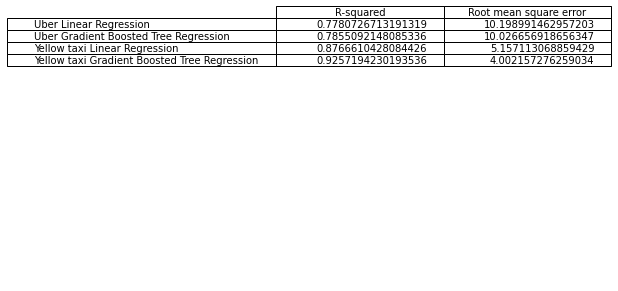

In [114]:
# create table for evaluation metrics, compare between Linear Regression model and Gradient Boosted
# Tree model
# set up row and column names
row = ['Uber Linear Regression', 'Uber Gradient Boosted Tree Regression',
      'Yellow taxi Linear Regression', 'Yellow taxi Gradient Boosted Tree Regression']
column = ['R-squared', 'Root mean square error']

# create a plot
fig, ax = plt.subplots(1,1)
ax.axis('off')
# allocate data with column and match row
celltext = [[uber_lr_r2,uber_lr_rmse],
            [uber_gbtr_r2,uber_gbtr_rmse],
            [ytaxi_lr_r2,ytaxi_lr_rmse], 
            [ytaxi_gbtr_r2,ytaxi_gbtr_rmse]
            ]

table = ax.table(cellText=celltext, rowLabels=row, colLabels=column,loc='top') 


# remove surrounding empty spaces for the table
bbox = table.get_window_extent(fig.canvas.get_renderer())
bbox_inches = bbox.transformed(fig.dpi_scale_trans.inverted())

# save the table figure
plt.savefig(directory + '/plots/Uber_vs_Yellow_taxi_evaluation_metric', dpi=300, bbox_inches=bbox_inches)

In [94]:
# calculate mean cost different between Uber and Yellow taxi, with the same prediction dataset
compare_ytaxi_gbtr["prediction"].mean() - compare_uber_gbtr["prediction"].mean()

3.2874749428022483